In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interpn
import os

import config
import utils

In [2]:
# Read measured profiles

measuredDoseFiles10 = ['./Measured/Method2/PDD_10x10.dat','./Measured/Method2/PROF1_10x10_100mm.dat','./Measured/Method2/PROF2_10x10_100mm.dat']
measuredDoseFiles30 = ['./Measured/Method2/PROF1_30x30_14mm.dat','./Measured/Method2/PROF2_30x30_14mm.dat','./Measured/Method2/PROF1_30x30_100mm.dat','./Measured/Method2/PROF2_30x30_100mm.dat']


clinicalProfiles = []

profiles = []
for n, measuredDoseFile in enumerate(measuredDoseFiles10):
    f = open(measuredDoseFile)
    lines = f.readlines()
    f.close()
    x = np.asarray([l.split() for l in lines[:-1]],dtype=np.float)
    x[:,0] = x[:,0]/10.
    interpRange = np.arange(x[0,0],x[x.shape[0]-1,0]+config.spaceStep/2,config.spaceStep)
    profile = interpn((x[:,0],),x[:,1] , interpRange)
    print(profile.shape,interpRange.shape,profile[0],profile[profile.shape[0]-1],interpRange[0],interpRange[interpRange.shape[0]-1])
    profiles.append(profile)

dum =np.zeros(config.numOfSimulatedProfileSamples,dtype=np.float)
np.copyto(dum[config.analyzedRanges[1][0][0]:config.analyzedRanges[1][0][1]],profiles[0][3:])
dum = dum*100.0/1.0186
clinicalProfiles.append(dum)                        #Field 10x10 depth profile from 0.3 to 30.0 (both included)

dum =np.zeros(config.numOfSimulatedProfileSamples,dtype=np.float)
np.copyto(dum[config.analyzedRanges[1][1][0]:config.analyzedRanges[1][1][1]],0.5*(profiles[1]+profiles[2]))
dum = dum*100.0/1.0186
clinicalProfiles.append(dum)                        #Field 10x10 lateral profile at depth 10cm from -8.8 to 8.8 cm, both included



profiles = []
for n, measuredDoseFile in enumerate(measuredDoseFiles30):
    f = open(measuredDoseFile)
    lines = f.readlines()
    f.close()
    x = np.asarray([l.split() for l in lines[:-1]],dtype=np.float)
    x[:,0] = x[:,0]/10.
    interpRange = np.arange(np.round(x[0,0],1)+config.spaceStep,np.round(x[x.shape[0]-1,0],1)-config.spaceStep/2,config.spaceStep)
#    print(interpRange[0],interpRange[interpRange.shape[0]-1])
    profile = interpn((x[:,0],),x[:,1] , interpRange)
    print(profile.shape,interpRange.shape,profile[0],profile[profile.shape[0]-1],interpRange[0],interpRange[interpRange.shape[0]-1])
    profiles.append(profile)

dum =np.zeros(config.numOfSimulatedProfileSamples,dtype=np.float)
np.copyto(dum[config.analyzedRanges[2][0][0]:config.analyzedRanges[2][0][1]],0.5*(profiles[0]+profiles[1]))
dum = dum*100/0.93433
clinicalProfiles.append(dum)                        #Field 30x30 lateral profile at depth 1.4cm from -18.2 to 18.2 cm, both included

dum =np.zeros(config.numOfSimulatedProfileSamples,dtype=np.float)
np.copyto(dum[config.analyzedRanges[2][1][0]:config.analyzedRanges[2][1][1]],0.5*(profiles[2]+profiles[3]))
dum = dum*100/0.93433
clinicalProfiles.append(dum)                        #Field 30x30 lateral profile at depth 10cm from -19.7 to 19.7 cm, both included
    
    
#plt.figure(figsize=(10,10))
#plt.plot(clinicalProfiles[0])
#plt.plot(clinicalProfiles[1])
#plt.show()
    
#plt.figure(figsize=(10,10))
#plt.plot(clinicalProfiles[2],'r-')            
#plt.plot(clinicalProfiles[3],'g-')            
#plt.show()


(301,) (301,) 0.68685 0.22172 0.0 30.0
(177,) (177,) 0.037411 0.03706100000000067 -8.8 8.799999999999937
(177,) (177,) 0.031121 0.03175100000000071 -8.8 8.799999999999937
(365,) (365,) 0.061570398422090736 0.06022178895462969 -18.2 18.200000000000518
(365,) (365,) 0.050342739644970415 0.048397512820506375 -18.2 18.200000000000518
(395,) (395,) 0.06757045454545456 0.0661409090909018 -19.7 19.70000000000056
(395,) (395,) 0.061083909090909105 0.060807545454537565 -19.7 19.70000000000056


In [3]:

means = np.load(config.modelDIR + config.meansFileName)
print(means.shape,clinicalProfiles[0].shape)      #(3, 6, 487) (487,)

diffTest = np.zeros((3,1,6,config.numOfSimulatedProfileSamples),dtype=np.float)

#Field 10
diff = clinicalProfiles[0] - means[1,0]
np.copyto(diffTest[1,0,0,:],diff)
diff = clinicalProfiles[1] - means[1,3]
np.copyto(diffTest[1,0,3,:],diff)

#Field 30
diff = clinicalProfiles[2] - means[2,1]
np.copyto(diffTest[2,0,1,:],diff)
diff = clinicalProfiles[3] - means[2,3]
np.copyto(diffTest[2,0,3,:],diff)

print(diffTest.shape)


(3, 6, 495) (495,)
(3, 1, 6, 495)


In [4]:
from sklearn.decomposition import PCA
import pickle


testFeatures = []

for nfield,(field,Ranges) in enumerate(zip(config.analyzedProfiles,config.analyzedRanges)):
    if field != None:
        for profile,Range in zip(field,Ranges):
            print(nfield,profile)
            pcaName = config.modelDIR + 'PCA_' + str(nfield) + '_' + str(profile) + '_.pkl'
            pca = pickle.load(open(pcaName,'rb'))

            X = diffTest[nfield][:,profile,Range[0]:Range[1]]
            X_projected = pca.transform(X)
            testFeatures.append(X_projected)

X_test = np.stack(testFeatures)
X_test = np.swapaxes(X_test,1,0)
X_test = np.reshape(X_test,(X_test.shape[0],X_test.shape[1]*X_test.shape[2]))  
print(X_test.shape)


1 0
1 3
2 1
2 3
(1, 12)


In [5]:
import matplotlib.pyplot as plt
from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV


preds = []
for goal in [0,1,2,3]:
    modelName = config.modelDIR + 'SVR_' + str(goal) + '_.pkl'
    clf = pickle.load(open(modelName,'rb'))
    predTest = clf.predict(X_test)
    preds.append(predTest[0])
    
print(preds)

[5.473108429436325, 0.5, 0.23119163574614376, 2.0814290243608427]


In [6]:
allMeans,allFieldFeatures,allFieldPCAModels = utils.allPCAResults()

In [7]:

recons = utils.reconstruct(preds,allMeans,allFieldFeatures,allFieldPCAModels)
print(preds)
print(utils.difference(preds,clinicalProfiles,allMeans,allFieldFeatures,allFieldPCAModels))   


[5.473108429436325, 0.5, 0.23119163574614376, 2.0814290243608427]
1314.7499802154666


In [12]:
# Optimize solution
# https://docs.scipy.org/doc/scipy/reference/tutorial/optimize.html
# https://scipy-lectures.org/advanced/mathematical_optimization/auto_examples/plot_non_bounds_constraints.html

preds = [5.501861,0.5,0.17502874, 2.407426] #- from DeepBeam

import scipy.optimize as opt
from scipy.optimize import SR1

def fun(cP,aM,aF,aPCA):
    def diff(y):
        return utils.difference(y,cP,aM,aF,aPCA)
    return diff

difference = fun(clinicalProfiles,allMeans,allFieldFeatures,allFieldPCAModels)

res = opt.minimize(difference, preds, method='SLSQP', jac="2-point",
               options={'ftol': 1e-9, 'disp': True},
               bounds=config.bounds)
print(res.x)

Optimization terminated successfully    (Exit mode 0)
            Current function value: 1011.4106644130508
            Iterations: 15
            Function evaluations: 82
            Gradient evaluations: 15
[5.60163013 0.5        0.24756439 2.38700187]


In [10]:
recons = utils.reconstruct(res.x,allMeans,allFieldFeatures,allFieldPCAModels)

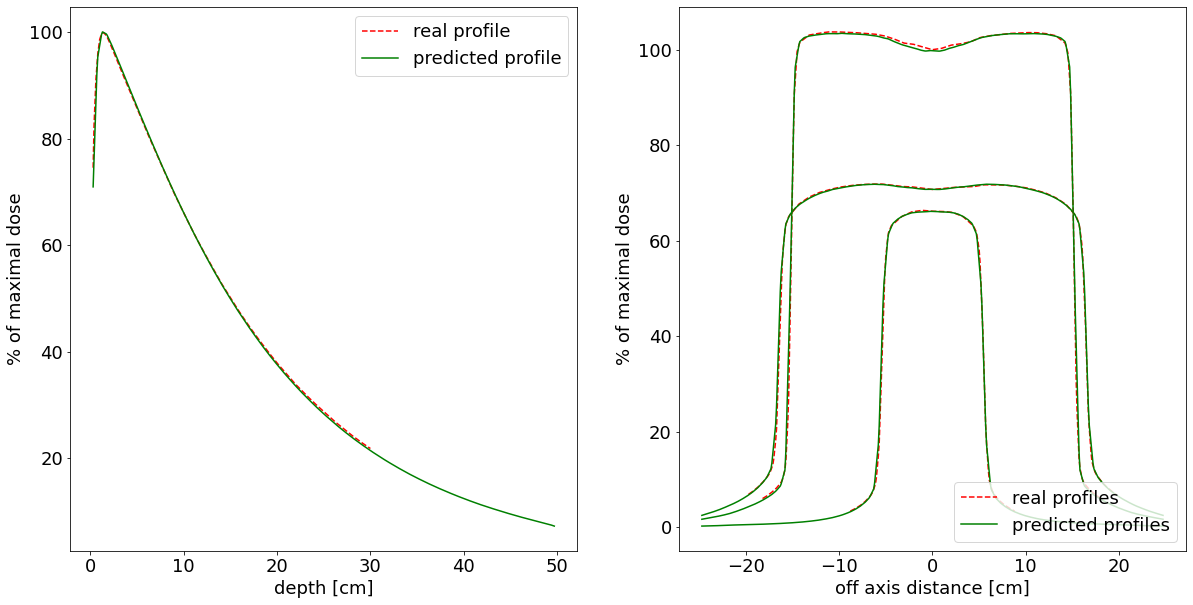

In [11]:
plt.rcParams.update({'font.size': 18})

fig, (axs1,axs2) = plt.subplots(1, 2,figsize = (20,10))

for n in [0]:
    axs1.plot(np.arange(0.3,30.05,0.1),clinicalProfiles[n][config.allRanges[n][0]:config.allRanges[n][1]],'r--',label='real profile')
    axs1.plot(np.arange(0.3,49.75,0.1),recons[n],'g-',label='predicted profile')

axs1.set(xlabel = 'depth [cm]',ylabel = '% of maximal dose')
axs1.legend(loc='upper right')

    
for n in [1,2,3]:
    start = config.allRanges[n][0]*0.1 -24.7
    end = config.allRanges[n][1]*0.1 - 24.7 - 0.05
    if n==1:
        axs2.plot(np.arange(start,end,0.1),clinicalProfiles[n][config.allRanges[n][0]:config.allRanges[n][1]],'r--',label='real profiles')
        axs2.plot(np.arange(-24.7,24.75,0.1),recons[n],'g-',label='predicted profiles')
    else:
        axs2.plot(np.arange(start,end,0.1),clinicalProfiles[n][config.allRanges[n][0]:config.allRanges[n][1]],'r--')
        axs2.plot(np.arange(-24.7,24.75,0.1),recons[n],'g-')

axs2.set(xlabel = 'off axis distance [cm]',ylabel = '% of maximal dose')
axs2.legend(loc='lower right')
plt.savefig('results2')
